In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn import metrics
from datetime import datetime
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import model_to_dot
from keras.utils import plot_model
from mlxtend.preprocessing import TransactionEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from statistics import variance
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier,ExtraTreesClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import KFold, cross_val_score,GridSearchCV
from sklearn.feature_selection import RFE
from xgboost import cv
from sklearn.metrics import make_scorer
from sklearn.utils.fixes import loguniform

### Read the Apt. Dataset

In [2]:
Apt_dataset=pd.read_csv("Apt_dataset.csv")

### Spliting the features and target Variable

In [3]:
X=Apt_dataset.drop(['List Price', 'Sold Price', 'Days on Market','Sale to List %','price class', 'log price'],axis=1)
Y=Apt_dataset[['Sold Price','log price',"price class",'List Price']]

### Dataset Standardization and scaling

In [4]:
from sklearn.preprocessing import StandardScaler
def X_norm(df):
    ndf=pd.DataFrame()
    for col in df.columns:
        #norm btw 0 and 1
        ndf[col]=df[col]/max(df[col])
    #Z_score for 'Taxes' and 'Maint. Fees'
    std_scaler = StandardScaler()
    ndf[['Taxes','Maint. Fees']] = std_scaler.fit_transform(ndf[['Taxes','Maint. Fees']].values.tolist())
    return ndf

nX=X_norm(X)
nY=Y.copy(deep=True)
_MAX_Y=max(Y['Sold Price'])
nY['Sold Price']=Y['Sold Price']/_MAX_Y
nY['List Price']=Y['List Price']/_MAX_Y

### Creating Training and Test Sets for the Apt dataset

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(nX, nY, test_size=0.15,stratify=nY[["price class"]])

### Goodness of fit function 

In [6]:
def GoF(y_true, y_pred,summary=True,plot=True,title='cumulative distribution of APE Curve'):
    APE=np.abs((y_true - y_pred) / y_true)
    score=[]
    N=len(y_true)
    for i in range(101):
        T=sum(APE<=i/100.0)
        score.append(T/N)
    AUC=np.trapz(score, dx=0.01)
    MAPE=np.average(np.abs(y_true - y_pred) / y_true, axis=0)*100
    RMSE=np.sqrt(mean_squared_error(y_true, y_pred))
    R2=r2_score(y_true, y_pred)
    dict_error={'Value':[_MAX_Y*RMSE,R2,MAPE,AUC]}
    index_error=['RMSE','R2','MAPE%',"AUC"]
    df = pd.DataFrame(dict_error,index=index_error)
    
    if plot:
        plt.figure(figsize=(5, 5))
        plt.plot(np.linspace(0,1.01,101),score,label=f'AUC = {round(AUC,2)}')
        plt.plot(0.05,score[5],'rs', label=f'APE<5% : {round(score[5]*100,2)}%')
        plt.plot(0.10,score[10],'rD', label=f'APE<10% : {round(score[10]*100,2)}%')
        plt.plot(0.20,score[20],'ro', label=f'APE<20% : {round(score[20]*100,2)}%')
        plt.legend()
        plt.title(title)
        plt.xlabel('APE')
        plt.ylabel('Cumulative distribution')
        plt.show()
        
    if summary:
        print(round(df,2).T)
        
    return score,df

######### Custom Grid Search score functions #########
def GS_score(y_true, y_pred):# y=Sold price 
    _,ES=GoF(y_true,y_pred,summary=False,plot=False)
    return (ES.T)['AUC'].values

def Log_GS_score(y_true, y_pred):# y=Log of sold price
    _,ES=GoF(np.exp(y_true),np.exp(y_pred),summary=False,plot=False)
    return (ES.T)['AUC'].values

######### Mean of APE curve & its margins ######### 
def CDF_plot(CDF_mean,CDF_std,title="K-Fold Result"):
    x=np.linspace(0,1.01,101)
    plt.figure(figsize=(5, 5))
    plt.plot(x,CDF_mean,label='mean')
    plt.plot(x,CDF_mean+2*CDF_std,'--',label='mean+2*std')
    plt.plot(x,CDF_mean-2*CDF_std,'--',label='mean-2*std')
    plt.legend()
    plt.title(title)
    plt.xlabel('APE')
    plt.ylabel('Cumulative distribution')
    plt.show()

### Base line

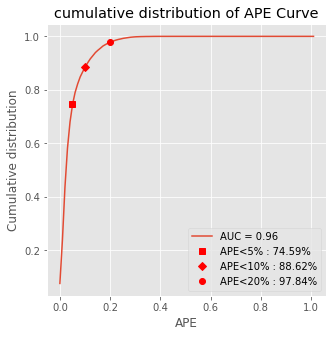

           RMSE    R2  MAPE%   AUC
Value  38636.45  0.96   4.16  0.96


In [13]:
######### The homeowner listed a value to sale as a list price ######### 
score,ES=GoF(nY['Sold Price'],nY['List Price'])

## Random Forest Model

### Target: Sold Price 

#### Hyperparameter Optimization With Grid Search 

In [8]:
param_grid = { 
    'n_estimators': range(300,1001,100),
    'max_depth' : range(5,31,5),
    'bootstrap': [True, False]
    }

AUC = make_scorer(GS_score)
rfr=RandomForestRegressor()
rf_tune =GridSearchCV(estimator=rfr, param_grid=param_grid,
                             cv = 5,
                             scoring=AUC,
                             n_jobs = -1)

rf_opt = rf_tune.fit(X_train, Y_train['Sold Price'])
print("Best AUC : " + str(rf_opt.best_score_) + "\n")
print("Optimal Model:\n" + str(rf_opt.best_estimator_) + "\n")
print(rf_opt.best_params_)

Best AUC : 0.9151676229597181

Optimal Model:
RandomForestRegressor(max_depth=30, n_estimators=400)

{'bootstrap': True, 'max_depth': 30, 'n_estimators': 400}


#### Find the optimal hyperparameters in a smaller range by Grid Search algorthim

In [10]:
param_grid = { 
    'n_estimators': range(350,451,10),
    'max_depth' : range(26,35)  
}
AUC = make_scorer(GS_score)
rfr=RandomForestRegressor(bootstrap=True)
rf_tune =GridSearchCV(estimator=rfr, param_grid=param_grid,
                             cv = 5,
                             scoring=AUC,
                             n_jobs = -1)

rf_opt = rf_tune.fit(X_train, Y_train['Sold Price'])
print("Best AUC : " + str(rf_opt.best_score_) + "\n")
print("Optimal Model:\n" + str(rf_opt.best_estimator_) + "\n")
print(rf_opt.best_params_)

Best AUC : 0.9151508450897117

Optimal Model:
RandomForestRegressor(max_depth=27, n_estimators=450)

{'max_depth': 27, 'n_estimators': 450}


#### Test the model with the best parameters and plot the result

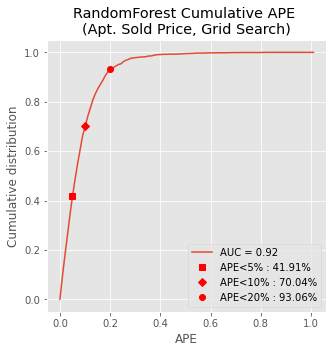

           RMSE   R2  MAPE%   AUC
Value  61200.32  0.9   8.36  0.92


In [12]:
grid_predictions = rf_opt.predict(X_test)
score,ES=GoF(Y_test['Sold Price'],grid_predictions,title="RandomForest Cumulative APE \n(Apt. Sold Price, Grid Search)")  

#### K-Fold Cross Validation, K=50

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50             mean       std
RMSE   61283.371  5272.966
R2         0.901     0.018
MAPE%      8.248     0.482
AUC        0.918     0.005


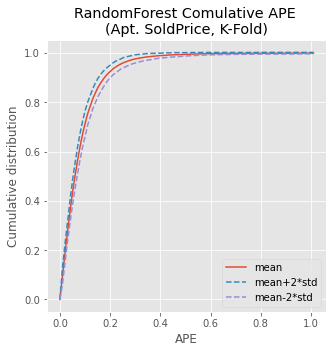

             mean       std
APE<5%   0.434956  0.024969
APE<10%  0.715758  0.025889
APE<20%  0.925918  0.012707


In [20]:
CDF=[]
dict_error={'Value':[0,0,0,0]}
index_error=['RMSE','R2','MAPE%',"AUC"]
ES = pd.DataFrame(dict_error,index=index_error)
num_fold=50
i=0
folds = KFold(n_splits = num_fold, shuffle = True, random_state = 100)
for train_index, test_index in folds.split(nX, nY):
    rfr=RandomForestRegressor(n_estimators=450,
                              max_depth=27,
                              bootstrap=True).fit(nX.iloc[train_index],
                                                  nY.iloc[train_index]['Sold Price'])
                                
    y_pred=rfr.predict(nX.iloc[test_index])
    cdf,es=GoF(nY.iloc[test_index]['Sold Price'],y_pred,summary=False,plot=False)
    
    CDF.append(cdf)
    ES[i]=es
    i+=1
    print(i,end=' ')
    
ES=ES.drop('Value',axis=1)
ES['mean']=ES.mean(axis=1)
ES['std']=ES.std(axis=1)
ES=ES[['mean','std']]    
print(ES.round(3))

CDF=np.array(CDF)
CDF_mean=CDF.mean(axis=0)
CDF_std=CDF.std(axis=0)
CDF_plot(CDF_mean,CDF_std,title="RandomForest Comulative APE \n(Apt. SoldPrice, K-Fold)")
dict_ACC={'mean':CDF_mean[[5,10,20]],'std':CDF_std[[5,10,20]]}
index_ACC=['APE<5%','APE<10%','APE<20%']
print(pd.DataFrame(dict_ACC,index=index_ACC))

#### Target: Log Price

#### Hyperparameter Optimization With Grid Search

In [21]:
param_grid = { 
    'n_estimators': range(300,1501,100),
    'max_depth' : range(5,41,5),    
}
AUC = make_scorer(Log_GS_score)
rfr=RandomForestRegressor()
rf_tune =GridSearchCV(estimator=rfr, param_grid=param_grid,
                             cv = 5,
                             scoring=AUC,
                             n_jobs = -1)
rf_opt = rf_tune.fit(X_train, Y_train['log price'])
print("Best AUC: " + str(rf_opt.best_score_) + "\n")
print("Optimal Model:\n" + str(rf_opt.best_estimator_) + "\n")
print(rf_opt.best_params_)

Best AUC: 0.9163651267718074

Optimal Model:
RandomForestRegressor(max_depth=30, n_estimators=600)

{'max_depth': 30, 'n_estimators': 600}


#### Find the optimal hyperparameters in a smaller range by the Grid Search algorthim

In [27]:
param_grid = { 
    'n_estimators': range(550,651,10),
    'max_depth' : range(25,35),
    
    
}
AUC = make_scorer(Log_GS_score)
rfr=RandomForestRegressor()
rf_tune =GridSearchCV(estimator=rfr, param_grid=param_grid,
                             cv = 5,
                             scoring=AUC,
                             n_jobs = -1)
rf_opt = rf_tune.fit(X_train, Y_train['log price'])
print("Best AUC: " + str(rf_opt.best_score_) + "\n")
print("Optimal Model:\n" + str(rf_opt.best_estimator_) + "\n")
print(rf_opt.best_params_)

Best AUC: 0.9163275632021886

Optimal Model:
RandomForestRegressor(max_depth=28, n_estimators=560)

{'max_depth': 28, 'n_estimators': 560}


#### Test the model with the best parameters  and plot the result

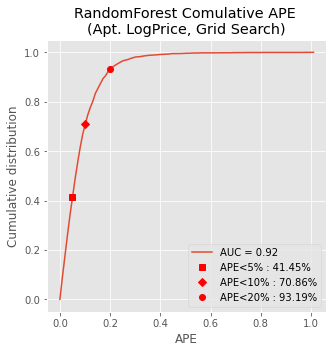

           RMSE   R2  MAPE%   AUC
Value  61507.16  0.9   8.24  0.92


In [28]:
grid_predictions = np.exp(rf_opt.predict(X_test))/_MAX_Y
score,ES=GoF(Y_test['Sold Price'],grid_predictions,title="RandomForest Comulative APE \n(Apt. LogPrice, Grid Search)") 

#### K-Fold Cross Validation, K=50

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 end
            mean       std
RMSE   61340.687  5313.841
R2         0.900     0.018
MAPE%      8.131     0.443
AUC        0.919     0.004


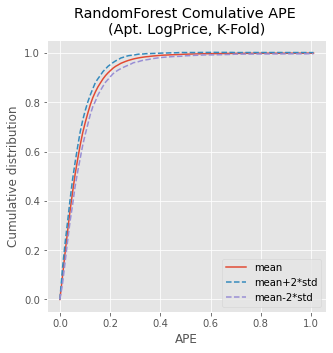

             mean       std
APE<5%   0.435349  0.025732
APE<10%  0.718265  0.024255
APE<20%  0.929456  0.012203


In [29]:
CDF=[]
dict_error={'Value':[0,0,0,0]}
index_error=['RMSE','R2','MAPE%',"AUC"]
ES = pd.DataFrame(dict_error,index=index_error)
num_fold=50
i=0
folds = KFold(n_splits = num_fold, shuffle = True, random_state = 100)
for train_index, test_index in folds.split(nX, nY):
    rfr=RandomForestRegressor(n_estimators=560,
                              max_depth=28,
                              bootstrap=True).fit(nX.iloc[train_index],
                                                  nY.iloc[train_index]['log price'])
                                
    y_pred=np.exp(rfr.predict(nX.iloc[test_index]))/_MAX_Y
    cdf,es=GoF(nY.iloc[test_index]['Sold Price'],y_pred,summary=False,plot=False)
    
    CDF.append(cdf)
    ES[i]=es
    i+=1
    print(i,end=" ")
print('end')
    
ES=ES.drop('Value',axis=1)
ES['mean']=ES.mean(axis=1)
ES['std']=ES.std(axis=1)
ES=ES[['mean','std']]    
print(ES.round(3))

CDF=np.array(CDF)
CDF_mean=CDF.mean(axis=0)
CDF_std=CDF.std(axis=0)
CDF_plot(CDF_mean,CDF_std,title="RandomForest Comulative APE \n(Apt. LogPrice, K-Fold)")
dict_ACC={'mean':CDF_mean[[5,10,20]],'std':CDF_std[[5,10,20]]}
index_ACC=['APE<5%','APE<10%','APE<20%']
print(pd.DataFrame(dict_ACC,index=index_ACC))

## XGBoost

### Sold Price

#### Hyperparameter Optimization With Grid Search 

In [22]:
parameters = {'n_estimators': range(100,700,50), 'max_depth':range(5,51,5)}
XGB_base =xgb.XGBRegressor()
AUC = make_scorer(GS_score)
XGB_tuned = GridSearchCV(XGB_base, parameters,
                         cv = 5,
                         scoring=AUC,
                         n_jobs = -1)

XGB_opt =XGB_tuned.fit(X_train, Y_train['Sold Price'])
print("Best AUC):" + str(XGB_opt.best_score_) + "\n")
#print("Optimal Model:\n" + str(XGB_opt.best_estimator_) + "\n")
print(XGB_opt.best_params_)

Best AUC):0.9238735171264277

{'max_depth': 5, 'n_estimators': 550}


#### Find the optimal hyperparameters in a smaller range by Grid Search algorthim

In [28]:
parameters = {'n_estimators': range(350,451,10), 'max_depth':range(2,10)}
XGB_base =xgb.XGBRegressor()
AUC = make_scorer(GS_score)
XGB_tuned = GridSearchCV(XGB_base, parameters,
                         cv = 5,
                         scoring=AUC,
                         n_jobs = -1)

XGB_opt =XGB_tuned.fit(X_train, Y_train['Sold Price'])
print("Best AUC):" + str(XGB_opt.best_score_) + "\n")
#print("Optimal Model:\n" + str(XGB_opt.best_estimator_) + "\n")
print(XGB_opt.best_params_)

Best ACC(APE<20%):0.944

{'max_depth': 5, 'n_estimators': 400}


#### Test the model with the best parameters and plot the result

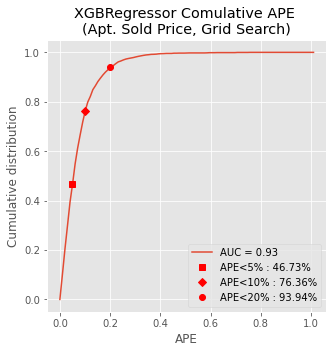

          RMSE    R2  MAPE%   AUC
Value  56059.0  0.92   7.39  0.93


In [35]:
                                     
grid_predictions = XGB_opt.predict(X_test)
score,ES=GoF(Y_test['Sold Price'],grid_predictions,title="XGBRegressor Comulative APE \n(Apt. Sold Price, Grid Search)")

#### K-Fold Cross Validation K=50

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50             mean       std
RMSE   31710.921  3189.961
R2         0.973     0.007
MAPE%      4.694     0.251
AUC        0.953     0.003


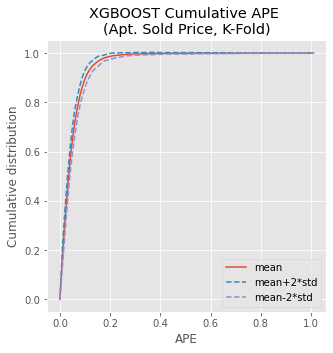

             mean       std
APE<5%   0.653273  0.027121
APE<10%  0.898555  0.016987
APE<20%  0.987325  0.006045


In [34]:
CDF=[]
dict_error={'Value':[0,0,0,0]}
index_error=['RMSE','R2','MAPE%',"AUC"]
ES = pd.DataFrame(dict_error,index=index_error)
num_fold=50
i=0
folds = KFold(n_splits = num_fold, shuffle = True, random_state = 100)
for train_index, test_index in folds.split(nX, nY):
    
    XGB_opt=xgb.XGBRegressor(n_estimators=400,
                         max_depth=5).fit(X_train,Y_train['Sold Price'])                                         
                            
    y_pred=XGB_opt.predict(nX.iloc[test_index])
    cdf,es=GoF(nY.iloc[test_index]['Sold Price'],y_pred,summary=False,plot=False)
    
    CDF.append(cdf)
    ES[i]=es
    i+=1
    print(i,end=' ')
    
ES=ES.drop('Value',axis=1)
ES['mean']=ES.mean(axis=1)
ES['std']=ES.std(axis=1)
ES=ES[['mean','std']]    
print(ES.round(3))

CDF=np.array(CDF)
CDF_mean=CDF.mean(axis=0)
CDF_std=CDF.std(axis=0)
CDF_plot(CDF_mean,CDF_std,title="XGBOOST Cumulative APE \n(Apt. Sold Price, K-Fold)")
dict_ACC={'mean':CDF_mean[[5,10,20]],'std':CDF_std[[5,10,20]]}
index_ACC=['APE<5%','APE<10%','APE<20%']
print(pd.DataFrame(dict_ACC,index=index_ACC))

#### Plot the CDF Values

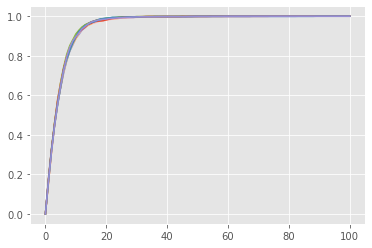

In [11]:
plt.plot(CDF.T)

### Log of Sold Price

#### Find the optimal hyperparameters in a smaller range by Grid Search algorthim

In [23]:
parameters = {'n_estimators': range(100,701,50), 'max_depth':range(3,51,5)}
XGB_base =xgb.XGBRegressor()
AUC = make_scorer(Log_GS_score)
XGB_tuned = GridSearchCV(XGB_base, parameters,
                         cv = 5,
                         scoring=AUC,
                         n_jobs = -1)

XGB_opt =XGB_tuned.fit(X_train, Y_train['log price'])
print("Best AUC:" + str(XGB_opt.best_score_) + "\n")
#print("Optimal Model:\n" + str(XGB_opt.best_estimator_) + "\n")
print(XGB_opt.best_params_)

Best AUC:0.9240099612862064

{'max_depth': 3, 'n_estimators': 700}


#### Find the optimal hyperparameters in a smaller range by Grid Search algorthim

In [32]:
parameters = {'n_estimators': range(700,1001,20), 'max_depth':range(2,10)}
XGB_base =xgb.XGBRegressor()
AUC = make_scorer(Log_GS_score)
XGB_tuned = GridSearchCV(XGB_base, parameters,
                         cv = 10,
                         scoring=AUC,
                         n_jobs = -1)

XGB_opt =XGB_tuned.fit(X_train, Y_train['log price'])
print("Best AUC):" + str(XGB_opt.best_score_) + "\n")
#print("Optimal Model:\n" + str(XGB_opt.best_estimator_) + "\n")
print(XGB_opt.best_params_)

Best ACC(APE<20%):0.9509999999999998

{'max_depth': 4, 'n_estimators': 700}


#### Test the model with the best parameters and plot the result

In [ ]:
                                                                
grid_predictions = np.exp(XGB_opt.predict(X_test))/_MAX_Y
score,ES=GoF(Y_test['Sold Price'],grid_predictions,title="XGBRegressor Comulative APE \n(Apt. log price, Grid Search)"

In [30]:
XGB_opt=xgb.XGBRegressor(max_depth=4,n_estimators=700).fit(X_train, Y_train['log price'])

In [31]:
grid_predictions = np.exp(XGB_opt.predict(X_test))/_MAX_Y

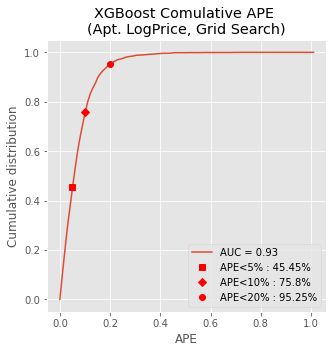

          RMSE    R2  MAPE%   AUC
Value  55235.7  0.92   7.21  0.93


In [32]:
score,ES=GoF(Y_test['Sold Price'],grid_predictions,title="XGBoost Comulative APE \n(Apt. LogPrice, Grid Search)") 

#### K-Fold cross validation,K=50 

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50             mean       std
RMSE   54113.980  4833.304
R2         0.922     0.015
MAPE%      7.084     0.363
AUC        0.929     0.004


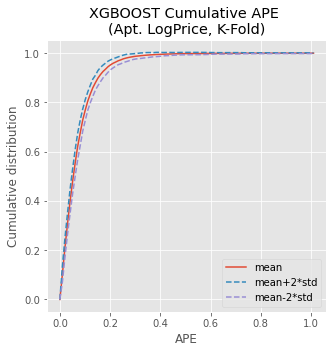

             mean       std
APE<5%   0.478190  0.025106
APE<10%  0.768816  0.021141
APE<20%  0.952645  0.009999


In [33]:
CDF=[]
dict_error={'Value':[0,0,0,0]}
index_error=['RMSE','R2','MAPE%',"AUC"]
ES = pd.DataFrame(dict_error,index=index_error)
num_fold=50
i=0
folds = KFold(n_splits = num_fold, shuffle = True, random_state = 100)
for train_index, test_index in folds.split(nX, nY):
    
    XGBoost=xgb.XGBRegressor(n_estimators=700,
                         max_depth=4).fit(nX.iloc[train_index],
                                                  nY.iloc[train_index]['log price'])
      
                                
    y_pred=np.exp(XGBoost.predict(nX.iloc[test_index]))/_MAX_Y
    cdf,es=GoF(nY.iloc[test_index]['Sold Price'],y_pred,summary=False,plot=False)
    
    CDF.append(cdf)
    ES[i]=es
    i+=1
    print(i,end=' ')
    
ES=ES.drop('Value',axis=1)
ES['mean']=ES.mean(axis=1)
ES['std']=ES.std(axis=1)
ES=ES[['mean','std']]    
print(ES.round(3))

CDF=np.array(CDF)
CDF_mean=CDF.mean(axis=0)
CDF_std=CDF.std(axis=0)
CDF_plot(CDF_mean,CDF_std,title="XGBOOST Cumulative APE \n(Apt. LogPrice, K-Fold)")
dict_ACC={'mean':CDF_mean[[5,10,20]],'std':CDF_std[[5,10,20]]}
index_ACC=['APE<5%','APE<10%','APE<20%']
print(pd.DataFrame(dict_ACC,index=index_ACC))

## SVR

### Sold Price

#### Find the optimal hyperparameters in a smaller range by Grid Search algorthim

In [24]:
parameters = {'kernel':('linear','poly','rbf'), 'C':range(1,30)}
SVR_base = SVR(degree=2) #defult()
AUC = make_scorer(GS_score)
SVR_tuned = GridSearchCV(estimator=SVR_base, param_grid=parameters,
                         cv = 5,scoring=AUC,n_jobs = -1)

SVR_opt =SVR_tuned.fit(X_train, Y_train['Sold Price'])
print("Best AUC: " + str(SVR_opt.best_score_) + "\n")
#print("Optimal Model:\n" + str(SVR_opt.best_estimator_) + "\n")
print(SVR_opt.best_params_)

Best AUC: 0.874732514075086

{'C': 1, 'kernel': 'linear'}


#### Find the optimal hyperparameters in a smaller range by Grid Search algorthim

In [36]:
parameters = {'kernel':('linear','poly','rbf'), 'C':range(30,60)}
SVR_base = SVR(degree=2) #defult()
AUC = make_scorer(GS_score)
SVR_tuned = GridSearchCV(estimator=SVR_base, param_grid=parameters,
                         cv = 5,scoring=AUC,n_jobs = -1)

SVR_opt =SVR_tuned.fit(X_train, Y_train['Sold Price'])
print("Best AUC: " + str(SVR_opt.best_score_) + "\n")
#print("Optimal Model:\n" + str(SVR_opt.best_estimator_) + "\n")
print(SVR_opt.best_params_)

Best ACC(APE<20%: 0.8140000000000001

{'C': 30, 'kernel': 'linear'}


In [39]:
parameters = {'C':[0.1*x for x in range(5,20)],'epsilon':[0.01*x for x in range(5,20)]}
SVR_base = SVR(kernel='linear')#defult()
AUC = make_scorer(GS_score)
SVR_tuned = GridSearchCV(estimator=SVR_base, param_grid=parameters,
                         cv = 5,scoring=AUC,n_jobs = -1)

SVR_opt =SVR_tuned.fit(X_train, Y_train['Sold Price'])
print("Best AUC: " + str(SVR_opt.best_score_) + "\n")
#print("Optimal Model:\n" + str(SVR_opt.best_estimator_) + "\n")
print(SVR_opt.best_params_)

Best ACC(APE<20%: 0.874

{'C': 0.5, 'epsilon': 0.05}


In [40]:
parameters = {'C':[0.1*x for x in range(1,6)],'epsilon':[0.01*x for x in range(1,6)]}
SVR_base = SVR(kernel='linear')#defult()
AUC = make_scorer(GS_score)
SVR_tuned = GridSearchCV(estimator=SVR_base, param_grid=parameters,
                         cv = 5,scoring=AUC,n_jobs = -1)

SVR_opt =SVR_tuned.fit(X_train, Y_train['Sold Price'])
print("Best AUC: " + str(SVR_opt.best_score_) + "\n")
#print("Optimal Model:\n" + str(SVR_opt.best_estimator_) + "\n")
print(SVR_opt.best_params_)

Best ACC(APE<20%: 0.8939999999999999

{'C': 0.1, 'epsilon': 0.01}


In [43]:
parameters = {'C':[0.02*x for x in range(1,6)],'epsilon':[0.002*x for x in range(1,6)]}
SVR_base = SVR(kernel='linear')#defult()
AUC = make_scorer(GS_score)
SVR_tuned = GridSearchCV(estimator=SVR_base, param_grid=parameters,
                         cv = 5,scoring=AUC,n_jobs = -1)

SVR_opt =SVR_tuned.fit(X_train, Y_train['Sold Price'])
print("Best AUC: " + str(SVR_opt.best_score_) + "\n")
#print("Optimal Model:\n" + str(SVR_opt.best_estimator_) + "\n")
print(SVR_opt.best_params_)

Best ACC(APE<20%: 0.8939999999999999

{'C': 0.02, 'epsilon': 0.002}


In [ ]:
#SVRegressor=SVR(kernel='rbf', C=0.4,epsilon=0.01).fit(X_train,Y_train['Sold Price'])
y_pred=SVR_opt.predict(SVRegressor.predict(X_test))
score,ES=GoF(Y_test['Sold Price'],y_pred)

#### Test the model with the best parameters and plot the result

In [35]:
SVRegressor=SVR(kernel='linear', C=0.1,epsilon=0.01).fit(X_train, Y_train['Sold Price'])

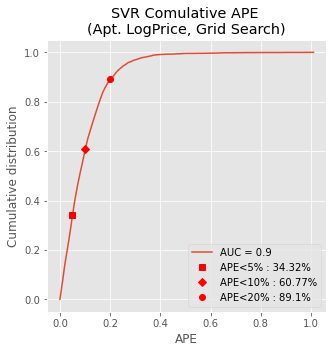

          RMSE    R2  MAPE%  AUC
Value  71153.7  0.87   9.94  0.9


In [36]:
grid_predictions=SVRegressor.predict(X_test)
score,ES=GoF(Y_test['Sold Price'],grid_predictions,title="SVR Comulative APE \n(Apt. SoldPrice, Grid Search)")
    

#### K-Fold Cross Validation, K=50

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50             mean       std
RMSE   71129.952  6226.172
R2         0.867     0.020
MAPE%      9.960     0.514
AUC        0.901     0.005


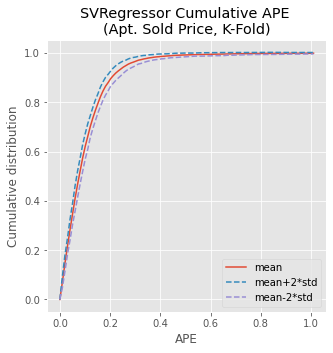

             mean       std
APE<5%   0.347069  0.021556
APE<10%  0.621383  0.025830
APE<20%  0.895264  0.015313


In [37]:
CDF=[]
dict_error={'Value':[0,0,0,0]}
index_error=['RMSE','R2','MAPE%',"AUC"]
ES = pd.DataFrame(dict_error,index=index_error)
num_fold=50
i=0
folds = KFold(n_splits = num_fold, shuffle = True, random_state = 100)
for train_index, test_index in folds.split(nX, nY):
    
    SVRegressor=SVR(kernel='linear', C=0.1,epsilon=0.01).fit(nX.iloc[train_index],
                                                  nY.iloc[train_index]['Sold Price'])                                    
                            
    y_pred=SVRegressor.predict(nX.iloc[test_index])
    cdf,es=GoF(nY.iloc[test_index]['Sold Price'],y_pred,summary=False,plot=False)
    
    CDF.append(cdf)
    ES[i]=es
    i+=1
    print(i,end=' ')
    
ES=ES.drop('Value',axis=1)
ES['mean']=ES.mean(axis=1)
ES['std']=ES.std(axis=1)
ES=ES[['mean','std']]    
print(ES.round(3))

CDF=np.array(CDF)
CDF_mean=CDF.mean(axis=0)
CDF_std=CDF.std(axis=0)
CDF_plot(CDF_mean,CDF_std,title="SVRegressor Cumulative APE \n(Apt. Sold Price, K-Fold)")
dict_ACC={'mean':CDF_mean[[5,10,20]],'std':CDF_std[[5,10,20]]}
index_ACC=['APE<5%','APE<10%','APE<20%']
print(pd.DataFrame(dict_ACC,index=index_ACC))

### Target: Log of the sold Price

#### Find the optimal hyperparameters by Grid Search algorthim

In [ ]:
parameters = {'kernel':('linear','poly','rbf'), 'C':range(1,30)}
SVR_base = SVR(degree=2) #defult()
AUC = make_scorer(Log_GS_score)
SVR_tuned = GridSearchCV(estimator=SVR_base, param_grid=parameters,
                         cv = 5,scoring=ACC,n_jobs = -1)
                                
SVR_opt =SVR_tuned.fit(X_train, Y_train['log price'])
print("Best AUC: " + str(SVR_opt.best_score_) + "\n")
#print("Optimal Model:\n" + str(SVR_opt.best_estimator_) + "\n")
print(SVR_opt.best_params_)

#### Find the optimal hyperparameters in a smaller range by Grid Search algorthim

In [48]:
parameters = {'C':[0.1*x for x in range(5,20)],'epsilon':[0.01*x for x in range(5,20)]}
SVR_base = SVR(kernel='rbf')#defult()
ACC = make_scorer(Log_GS_score)
SVR_tuned = GridSearchCV(estimator=SVR_base, param_grid=parameters,
                         cv = 5,scoring=ACC,n_jobs = -1)

SVR_opt =SVR_tuned.fit(X_train, Y_train['log price'])
print("Best ACC(APE<20%: " + str(SVR_opt.best_score_) + "\n")
#print("Optimal Model:\n" + str(SVR_opt.best_estimator_) + "\n")
print(SVR_opt.best_params_)

Best ACC(APE<20%: 0.922

{'C': 0.5, 'epsilon': 0.05}


In [49]:
parameters = {'C':[0.1*x for x in range(1,6)],'epsilon':[0.01*x for x in range(1,6)]}
SVR_base = SVR(kernel='rbf')#defult()
ACC = make_scorer(Log_GS_score)
SVR_tuned = GridSearchCV(estimator=SVR_base, param_grid=parameters,
                         cv = 5,scoring=ACC,n_jobs = -1)

SVR_opt =SVR_tuned.fit(X_train, Y_train['log price'])
print("Best ACC(APE<20%: " + str(SVR_opt.best_score_) + "\n")
#print("Optimal Model:\n" + str(SVR_opt.best_estimator_) + "\n")
print(SVR_opt.best_params_)

Best ACC(APE<20%: 0.922

{'C': 0.4, 'epsilon': 0.01}


#### Test the model with the best parameters and plot the result

           RMSE   R2  MAPE%   AUC
Value  62871.48  0.9   8.67  0.91


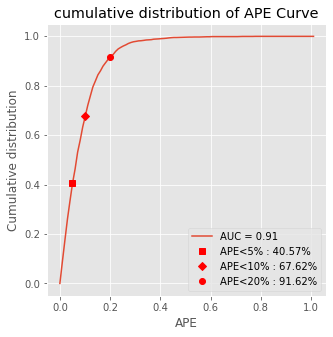

In [12]:
SVRegressor=SVR(kernel='rbf', C=0.4,epsilon=0.01).fit(X_train,Y_train['log price'])
y_pred=np.exp(SVRegressor.predict(X_test))/_MAX_Y
score,ES=GoF(Y_test['Sold Price'],y_pred)

### K-Fold Cross Validation,K=50

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50              mean        std
RMSE   100888.554  24217.575
R2          0.725      0.117
MAPE%      10.669      0.616
AUC         0.894      0.006


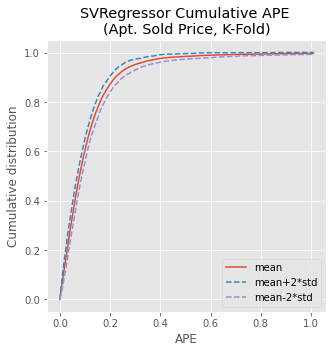

             mean       std
APE<5%   0.342793  0.025026
APE<10%  0.609548  0.023758
APE<20%  0.876301  0.016170


In [38]:
CDF=[]
dict_error={'Value':[0,0,0,0]}
index_error=['RMSE','R2','MAPE%',"AUC"]
ES = pd.DataFrame(dict_error,index=index_error)
num_fold=50
i=0
folds = KFold(n_splits = num_fold, shuffle = True, random_state = 100)
for train_index, test_index in folds.split(nX, nY):
    
    SVRegressor=SVR(kernel='linear', C=0.4,epsilon=0.01).fit(nX.iloc[train_index],
                                                  nY.iloc[train_index]['log price'])                                    
                            
    y_pred=np.exp(SVRegressor.predict(nX.iloc[test_index]))/_MAX_Y
    cdf,es=GoF(nY.iloc[test_index]['Sold Price'],y_pred,summary=False,plot=False)
    
    CDF.append(cdf)
    ES[i]=es
    i+=1
    print(i,end=' ')
    
ES=ES.drop('Value',axis=1)
ES['mean']=ES.mean(axis=1)
ES['std']=ES.std(axis=1)
ES=ES[['mean','std']]    
print(ES.round(3))

CDF=np.array(CDF)
CDF_mean=CDF.mean(axis=0)
CDF_std=CDF.std(axis=0)
CDF_plot(CDF_mean,CDF_std,title="SVRegressor Cumulative APE \n(Apt. Sold Price, K-Fold)")
dict_ACC={'mean':CDF_mean[[5,10,20]],'std':CDF_std[[5,10,20]]}
index_ACC=['APE<5%','APE<10%','APE<20%']
print(pd.DataFrame(dict_ACC,index=index_ACC))

### Scores (The 100 scors points above graph)

In [90]:
SS=np.round(score,4)*100
print(SS)

[  0.     9.79  20.5   29.57  38.44  46.59  53.67  60.02  65.95  71.35
  75.47  78.98  82.35  85.76  88.18  89.78  90.86  92.11  93.09  94.07
  95.22  95.71  96.23  96.59  96.95  97.41  97.74  97.9   98.23  98.49
  98.62  98.95  99.02  99.12  99.31  99.38  99.54  99.54  99.57  99.61
  99.61  99.64  99.67  99.67  99.74  99.74  99.74  99.8   99.8   99.8
  99.8   99.8   99.84  99.84  99.84  99.84  99.84  99.84  99.87  99.87
  99.9   99.93  99.93  99.93  99.93  99.93  99.93  99.93  99.93  99.93
  99.97  99.97  99.97  99.97  99.97  99.97  99.97  99.97  99.97  99.97
  99.97  99.97  99.97  99.97  99.97  99.97 100.   100.   100.   100.
 100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
 100.  ]


In [95]:
SS[1]

9.790000000000001

In [91]:
SS[5]

46.589999999999996

In [96]:
SS[10]

75.47

In [93]:
SS[15]

89.78

In [97]:
SS[20]

95.22

In [94]:
SS[86]

100.0